### Test case LVV-T38: Verify implementation of Processed Visit Images
Verify that the DMS
1. Successfully produces Processed Visit Images, where the instrument signature has been removed.
2. Successfully combines images obtained during a standard visit.

In [1]:
# Print the version of the Science Pipelines being used:
! echo $HOSTNAME
! eups list -s | grep lsst_distrib

jcarlin-nb
lsst_distrib          gdfb3db0272+d933a7c716 	current w_2025_29 w_latest setup


In [2]:
from lsst.daf.butler import Butler
import numpy as np
import random
%matplotlib inline
import matplotlib.pyplot as plt
from astropy.visualization import (MinMaxInterval, AsinhStretch, ZScaleInterval, LogStretch, LinearStretch,
                                   ImageNormalize)
import lsst.afw.display as afwDisplay
import lsst.geom as geom

In [3]:
zscale = ZScaleInterval()

# Set up some plotting defaults:
plt.rcParams.update({'figure.figsize' : (12, 8)})
plt.rcParams.update({'font.size' : 14})
plt.rcParams.update({'axes.linewidth' : 3})
plt.rcParams.update({'axes.labelweight' : 3})
plt.rcParams.update({'axes.titleweight' : 3})
plt.rcParams.update({'ytick.major.width' : 3})
plt.rcParams.update({'ytick.minor.width' : 2})
plt.rcParams.update({'ytick.major.size' : 8})
plt.rcParams.update({'ytick.minor.size' : 5})
plt.rcParams.update({'xtick.major.size' : 8})
plt.rcParams.update({'xtick.minor.size' : 5})
plt.rcParams.update({'xtick.major.width' : 3})
plt.rcParams.update({'xtick.minor.width' : 2})
plt.rcParams.update({'xtick.direction' : 'in'})
plt.rcParams.update({'ytick.direction' : 'in'})

### Load and examine an LSSTComCam processed visit image

In [4]:
collection = "LSSTComCam/runs/DRP/DP1/v29_0_0/DM-50260"
repo = "/repo/dp1"
butler = Butler.from_config(repo, collections=collection)

In [5]:
visim_refs = butler.query_datasets('visit_image')

# Use the first image from the query results:
dataid_visim = visim_refs[0].dataId

# Raw images use "exposure" dimension instead of "visit":
dataid_raw = dataid_visim.to_simple().dataId
dataid_raw['exposure'] = dataid_raw['visit']

In [6]:
# Load the visit_image
visim = butler.get('visit_image', dataId=dataid_visim)

# Load the raw image
raw = butler.get('raw', dataId=dataid_raw)

In [7]:
# Extract the images and normalize them:
im = visim.image.array

# Create an ImageNormalize object
norm = ImageNormalize(im, interval=ZScaleInterval(),
                      stretch=LinearStretch())

rawim = raw.image.array

# Create an ImageNormalize object
rawnorm = ImageNormalize(rawim, interval=ZScaleInterval(),
                         stretch=LinearStretch())

### Confirm that the overscan has been trimmed

To do so, compare the size of the raw image and the visit image. The visit_image should have fewer pixels because its overscan has been trimmed.

In [8]:
print(f"raw bounding box: {raw.getBBox()}")
print(f"visit_image bounding box: {visim.getBBox()}")

raw bounding box: (minimum=(0, 0), maximum=(4607, 4095))
visit_image bounding box: (minimum=(0, 0), maximum=(4071, 3999))


We see that the visit_image has indeed been trimmed.

### Compare the original image and the processed visit image (aka "visit_image")

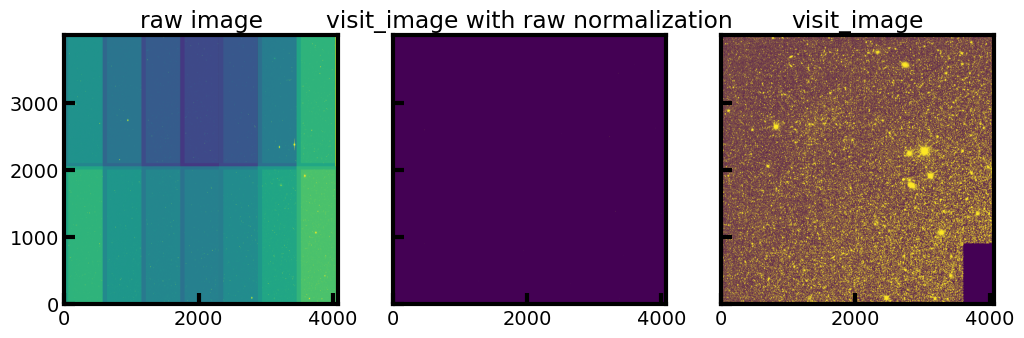

In [9]:
ncols = 3
nrows = 1
f, ax = plt.subplots(nrows=int(np.ceil(nrows)), ncols=int(ncols), sharey=True, sharex=True, figsize=(12,10))
axs = ax.flatten()

axs[0].imshow(rawim, norm=rawnorm, origin='lower')
axs[0].set_title('raw image')
axs[1].imshow(im, norm=rawnorm, origin='lower')
axs[1].set_title('visit_image with raw normalization')
axs[2].imshow(im, norm=norm, origin='lower')
axs[2].set_title('visit_image')
plt.show()

The image has clearly undergone ISR corrections, as evidenced by the fact that the total count rate is lower (middle image vs. the raw), and that the amplifier regions are no longer visible (compare right image to the raw).

### Confirm that the visit_image contains mask and variance planes

In [10]:
# Extract the images and normalize them:
mask = visim.maskedImage

# Extract the images and normalize them:
variance = visim.variance.array

# Create an ImageNormalize object
variancenorm = ImageNormalize(variance, interval=ZScaleInterval(),
                              stretch=LinearStretch())

#### Display the variance plane:

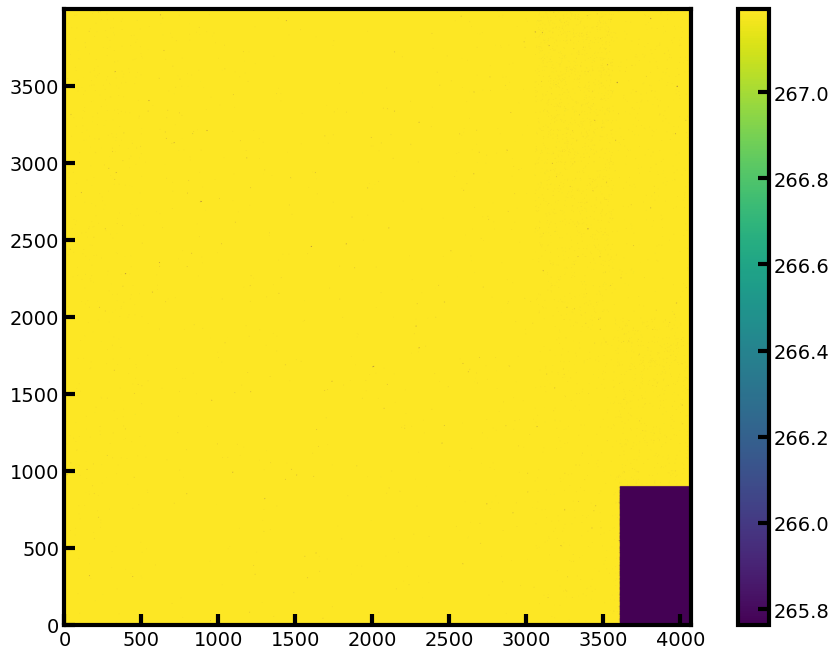

In [11]:
plt.imshow(variance, norm=variancenorm, origin='lower')
plt.colorbar()
plt.show()

#### Display the masked image:

<Figure size 1200x800 with 0 Axes>

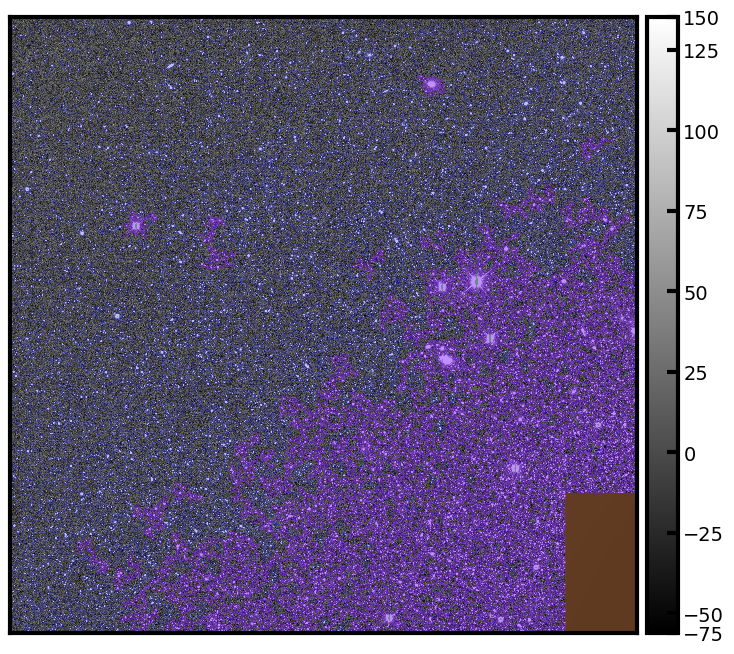

In [12]:
afwDisplay.setDefaultBackend('matplotlib') 
plt.figure()
afw_display = afwDisplay.Display()
afw_display.scale('linear', 'zscale')
afw_display.mtv(mask)
plt.xticks([])
plt.yticks([])
plt.show()

In [13]:
# The MaskedImage is overplotting the values of the mask plane. 
# Extract the mapping between mask color and mask bit directly from the mask object:

for maskName, maskBit in mask.mask.getMaskPlaneDict().items():
    print('{}: {}'.format(afw_display.getMaskPlaneColor(maskName),maskName))


red: BAD
magenta: CR
blue: CROSSTALK
blue: DETECTED
cyan: DETECTED_NEGATIVE
yellow: EDGE
green: INTRP
cyan: ITL_DIP
magenta: NOT_DEBLENDED
orange: NO_DATA
green: SAT
green: STREAK
yellow: SUSPECT
yellow: UNMASKEDNAN
red: VIGNETTED


#### Confirm that the crosstalk correction has been applied and its pixel mask set:

<Figure size 1200x800 with 0 Axes>

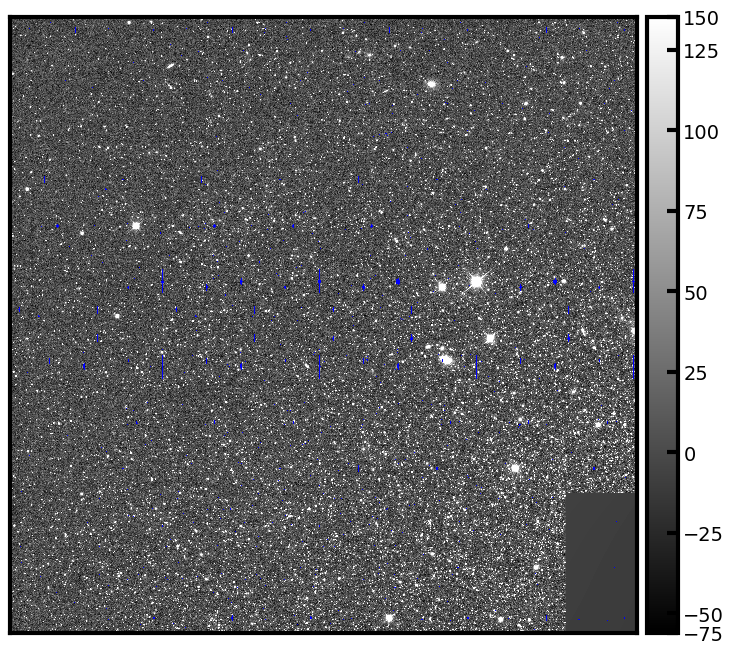

In [14]:
plt.figure()
afw_display = afwDisplay.Display()
afw_display.setMaskTransparency(100)
afw_display.setMaskTransparency(0, 'CROSSTALK')
afw_display.scale('linear', 'zscale')
afw_display.mtv(mask)
plt.xticks([])
plt.yticks([])
plt.show()

The masked image shows that pixels expected to be affected by crosstalk have been corrected and flagged in the mask plane.

#### Confirm that the WCS is present with the visit_image

In [15]:
# First, check the result of the "hasWcs" method:
visim.hasWcs()

True

In [16]:
# OK, the Butler claims that the image has a WCS. Now check the WCS.

# Load the source catalog
src = butler.get('source', dataId = dataid_visim)

# Extract the WCS:
wcs = visim.getWcs()

# Start from XY, then use the WCS to convert to RA, Dec:
xxx = src['x']
yyy = src['y']
radec = wcs.pixelToSkyArray(xxx, yyy, degrees=True)

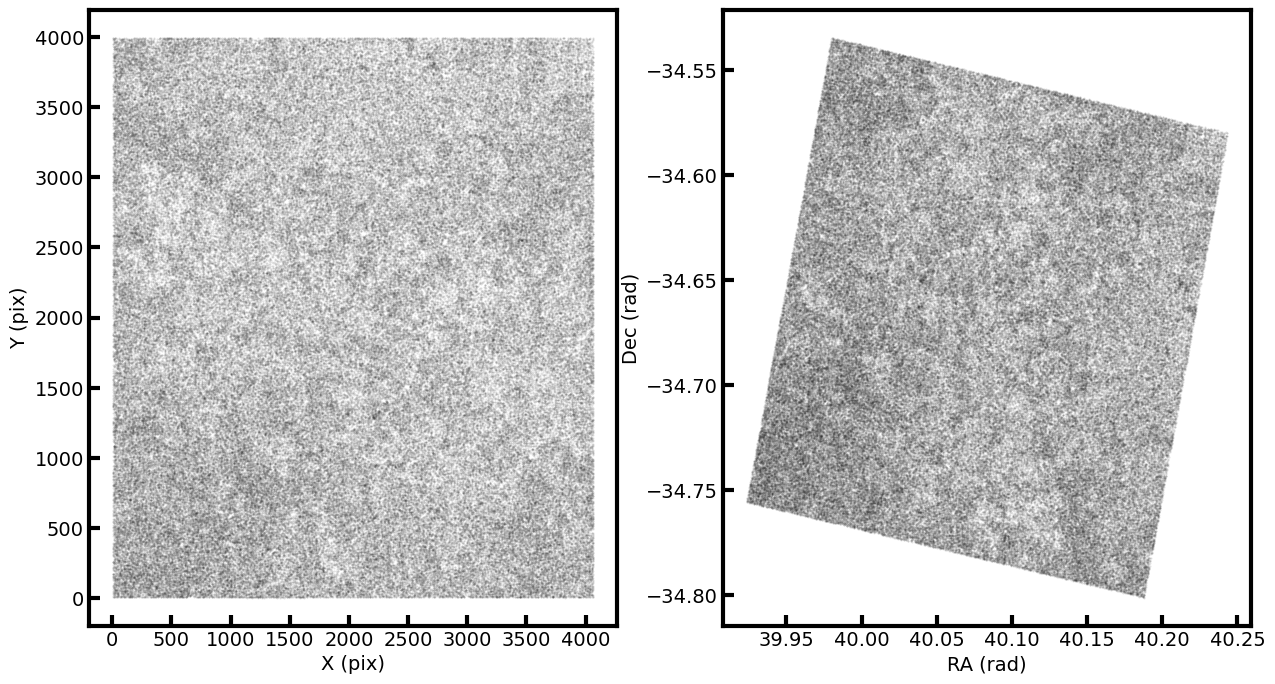

In [18]:
plt.rcParams.update({'figure.figsize' : (15, 8)})

plt.subplot(121)
plt.plot(xxx, yyy, 'k.', ms=1, alpha=0.1)
plt.xlabel('X (pix)')
plt.ylabel('Y (pix)')

plt.subplot(122)
plt.plot(radec[0], radec[1], 'k.', ms=1, alpha=0.1)

plt.xlabel('RA (rad)')
plt.ylabel('Dec (rad)')
plt.show()

The positions seem to have reasonably converted from (X, Y) to (RA, Dec). We thus consider this portion of the test to have passed.

#### Confirm that the PSF is available and can be extracted

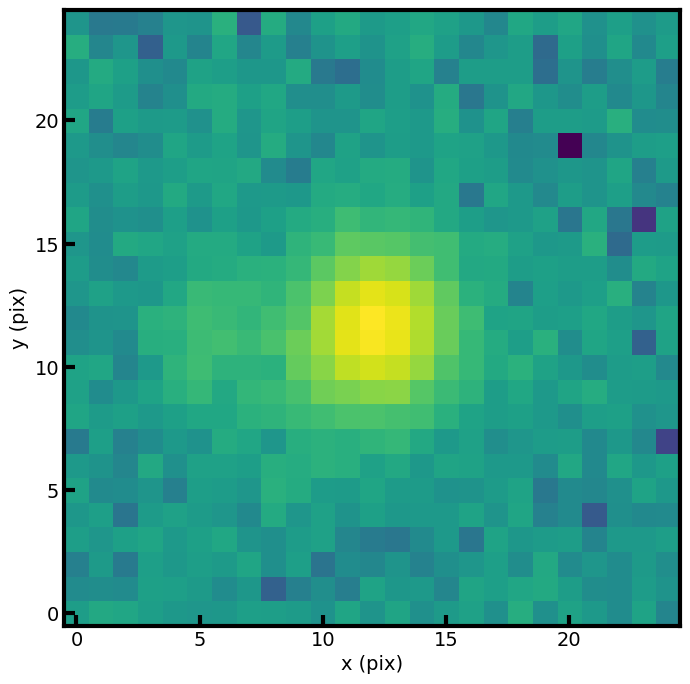

In [19]:
# Extract an image of the PSF at a random point and display it:
psf = visim.getPsf()

xsize = visim.getDimensions().getX()
ysize = visim.getDimensions().getY()
# Select a random point on the image and extract the PSF at that point:
xpt = random.random()*xsize
ypt = random.random()*ysize
psfimage = psf.computeImage(geom.PointD(xpt, ypt))
img = psfimage.array

# Create an ImageNormalize object
norm = ImageNormalize(img, interval=MinMaxInterval(),
                      stretch=LogStretch())

plt.imshow(img, norm=norm, origin='lower')
plt.xlabel('x (pix)')
plt.ylabel('y (pix)')
plt.show()

This is a well-formed image of a reasonable-looking PSF. We thus consider this portion of the test to have passed.

# Result

A randomly-selected Processed Visit Image (datasetType: "visit_image") has been retrieved, and we have demonstrated that it has had instrument signature corrections applied. The image has mask and variance planes, a WCS, and a PSF object associated with it.